# Lab 12-2 Many To One Stacking
## What is "Stacking"?
-  CNN처럼 RNN도 여러개의 Layer를 쌓을 수 있음(**Multi-layered RNN** 또는 **Stacked RNN**)
- 경험적으로 Stacked RNN이 shallow RNN보다 성능이 뛰어나다고 알려져 있음
- Input에 가까운 hidden state는 Syntactic information을 더 잘 Encoding함
- Output에 가까운 hidden state는 Semantic information을 더 잘 Encoding함
- 이번 강의에서는 Stacked RNN을 Many To One 형식으로 나타내는 것
    - 마지막 RNN이 출력한 token과 정답 사이의 loss 계산
    - 이 loss로 stacked RNN을 Backpropagation을 통해 학습

In [1]:
# setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
%matplotlib inline

print(tf.__version__)

2.3.0


### Prepairing Dataset

In [2]:
# example data
sentences = ['What I cannot create, I do not understand.',
             'Intellecuals solve problems, geniuses prevent them',
             'A person who never made a mistake never tied anything new.',
             'The same equations have the same solutions.']
y_data = [1,0,0,1] # 1: richard feynman, 0: albert einstein

In [3]:
# creating a token dictionary
char_set = ['<pad>'] + sorted(list(set(''.join(sentences))))
idx2char = {idx : char for idx, char in enumerate(char_set)}
char2idx = {char : idx for idx, char in enumerate(char_set)}

print(char_set)
print(idx2char)
print(char2idx)

['<pad>', ' ', ',', '.', 'A', 'I', 'T', 'W', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y']
{0: '<pad>', 1: ' ', 2: ',', 3: '.', 4: 'A', 5: 'I', 6: 'T', 7: 'W', 8: 'a', 9: 'b', 10: 'c', 11: 'd', 12: 'e', 13: 'g', 14: 'h', 15: 'i', 16: 'k', 17: 'l', 18: 'm', 19: 'n', 20: 'o', 21: 'p', 22: 'q', 23: 'r', 24: 's', 25: 't', 26: 'u', 27: 'v', 28: 'w', 29: 'y'}
{'<pad>': 0, ' ': 1, ',': 2, '.': 3, 'A': 4, 'I': 5, 'T': 6, 'W': 7, 'a': 8, 'b': 9, 'c': 10, 'd': 11, 'e': 12, 'g': 13, 'h': 14, 'i': 15, 'k': 16, 'l': 17, 'm': 18, 'n': 19, 'o': 20, 'p': 21, 'q': 22, 'r': 23, 's': 24, 't': 25, 'u': 26, 'v': 27, 'w': 28, 'y': 29}


In [4]:
# converting sequence of tokens to sequence of indices
x_data = list(map(lambda sentence : [char2idx.get(char) for char in sentence], sentences))
x_data_len = list(map(lambda sentence : len(sentence), sentences))

print(x_data)
print(x_data_len) # 각 Sequence의 길이 list
print(y_data)

[[7, 14, 8, 25, 1, 5, 1, 10, 8, 19, 19, 20, 25, 1, 10, 23, 12, 8, 25, 12, 2, 1, 5, 1, 11, 20, 1, 19, 20, 25, 1, 26, 19, 11, 12, 23, 24, 25, 8, 19, 11, 3], [5, 19, 25, 12, 17, 17, 12, 10, 26, 8, 17, 24, 1, 24, 20, 17, 27, 12, 1, 21, 23, 20, 9, 17, 12, 18, 24, 2, 1, 13, 12, 19, 15, 26, 24, 12, 24, 1, 21, 23, 12, 27, 12, 19, 25, 1, 25, 14, 12, 18], [4, 1, 21, 12, 23, 24, 20, 19, 1, 28, 14, 20, 1, 19, 12, 27, 12, 23, 1, 18, 8, 11, 12, 1, 8, 1, 18, 15, 24, 25, 8, 16, 12, 1, 19, 12, 27, 12, 23, 1, 25, 15, 12, 11, 1, 8, 19, 29, 25, 14, 15, 19, 13, 1, 19, 12, 28, 3], [6, 14, 12, 1, 24, 8, 18, 12, 1, 12, 22, 26, 8, 25, 15, 20, 19, 24, 1, 14, 8, 27, 12, 1, 25, 14, 12, 1, 24, 8, 18, 12, 1, 24, 20, 17, 26, 25, 15, 20, 19, 24, 3]]
[42, 50, 58, 43]
[1, 0, 0, 1]


In [5]:
# padding the sequence of indices
max_sequence = 55
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence,
                       padding = 'post', truncating = 'post')

# checking data
print(x_data)
print(x_data_len)
print(y_data)

[[ 7 14  8 25  1  5  1 10  8 19 19 20 25  1 10 23 12  8 25 12  2  1  5  1
  11 20  1 19 20 25  1 26 19 11 12 23 24 25  8 19 11  3  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 5 19 25 12 17 17 12 10 26  8 17 24  1 24 20 17 27 12  1 21 23 20  9 17
  12 18 24  2  1 13 12 19 15 26 24 12 24  1 21 23 12 27 12 19 25  1 25 14
  12 18  0  0  0  0  0]
 [ 4  1 21 12 23 24 20 19  1 28 14 20  1 19 12 27 12 23  1 18  8 11 12  1
   8  1 18 15 24 25  8 16 12  1 19 12 27 12 23  1 25 15 12 11  1  8 19 29
  25 14 15 19 13  1 19]
 [ 6 14 12  1 24  8 18 12  1 12 22 26  8 25 15 20 19 24  1 14  8 27 12  1
  25 14 12  1 24  8 18 12  1 24 20 17 26 25 15 20 19 24  3  0  0  0  0  0
   0  0  0  0  0  0  0]]
[42, 50, 58, 43]
[1, 0, 0, 1]


### Create Model
- `layers.Embedding()` : one-hot vector로 encoding

In [6]:
# creating stacked rnn for "many to one" classification with dropout
num_classes = 2
hidden_dims = [10,10]

input_dim = len(char2idx)
output_dim = len(char2idx)
one_hot = np.eye(len(char2idx))

model = Sequential()
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim,
                           trainable=False, mask_zero=True, input_length=max_sequence,
                           embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(layers.SimpleRNN(units=hidden_dims[0], return_sequences=True))
model.add(layers.TimeDistributed(layers.Dropout(rate = .2)))
model.add(layers.SimpleRNN(units=hidden_dims[1]))
model.add(layers.Dropout(rate = .2))
model.add(layers.Dense(units=num_classes))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 55, 30)            900       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 55, 10)            410       
_________________________________________________________________
time_distributed (TimeDistri (None, 55, 10)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
Total params: 1,542
Trainable params: 642
Non-trainable params: 900
______________________________________________________

### Training Model

In [8]:
# creating loss function
def loss_fn(model, x, y, training):    
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x, training), from_logits=True))

# creating and optimizer
lr = .01 # Learning Rate
epochs = 30
batch_size = 2
opt = tf.keras.optimizers.Adam(learning_rate = lr)

In [9]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size=batch_size)

print(tr_dataset)

<BatchDataset shapes: ((None, 55), (None,)), types: (tf.int32, tf.int32)>


In [10]:
# training
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb, training=True)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)
    
    if (epoch + 1) % 5 ==0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss.numpy()))

epoch :   5, tr_loss : 0.033
epoch :  10, tr_loss : 0.016
epoch :  15, tr_loss : 0.010
epoch :  20, tr_loss : 0.001
epoch :  25, tr_loss : 0.006
epoch :  30, tr_loss : 0.015


### Checking Performance

In [11]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1)
print('accuracy : {:.2%}'.format(np.mean(yhat == y_data)))

accuracy : 100.00%


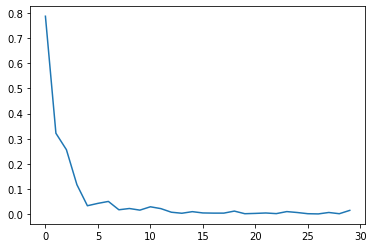

In [12]:
plt.plot(tr_loss_hist)